In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import enum
import random
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2

EXPERT_PATH = ['subject1.h5','subject2.h5','subject3.h5','subject4.h5','subject6.h5']


In [2]:
combined_df = pd.DataFrame()  # Create an empty DataFrame to store the combined data

for path in EXPERT_PATH:
    try:
        data = pd.read_hdf(path)
        combined_df = pd.concat([combined_df, data])  # Concatenate the current file's data to the combined DataFrame
    except FileNotFoundError:
        print('File {} not found'.format(path))


expert_data =combined_df
type(expert_data)

pandas.core.frame.DataFrame

In [3]:
print ([i for i in combined_df["bpm"] if i!= 85])

[76.0, 76.0, 76.0, 76.0, 76.0, 76.0, 72.0, 72.0, 72.0, 72.0, 78.0, 78.0, 78.0, 78.0, 78.0, 78.0, 78.0, 78.0, 72.0, 72.0, 72.0, 72.0, 72.0, 75.0]


In [4]:
expert_data.columns

Index(['midi_filename', 'username', 'practice_mode', 'bpm',
       'error_before_left_timing', 'error_before_right_timing',
       'error_before_left_pitch', 'error_before_right_pitch',
       'error_after_left_timing', 'error_after_right_timing',
       'error_after_left_pitch', 'error_after_right_pitch'],
      dtype='object')

In [5]:
# Sort the data by 'midi_filename' and 'username' columns
expert_data = expert_data.sort_values(by=['midi_filename', 'username'])

# Group the data by 'midi_filename' and 'username'
grouped_data = expert_data.groupby(['midi_filename', 'username'])

train_data = pd.DataFrame()
test_data = pd.DataFrame()

# Iterate over each group
for group_key, group_df in grouped_data:
    # Check the number of points in the group
    group_size = len(group_df)

    if group_size > 1:
        np.random.seed(42)
# Perform the train-test split with shuffle=False
        train_group, test_group = train_test_split(group_df, test_size=1, shuffle=True)

        # Append train group to train data
        train_data = pd.concat([train_data, train_group])

        # Append test group to test data
        test_data = pd.concat([test_data, test_group])
    else:
        # Add the whole group to the training data
        train_data = pd.concat([train_data, group_df])

# Randomly choose a third of the points in test and move them to train
test_size = len(test_data)
train_size = len(train_data)
print (train_size, test_size)

# Reset the index of train and test data
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

whole_data = expert_data.copy()
expert_data = whole_data #train_data


79 21


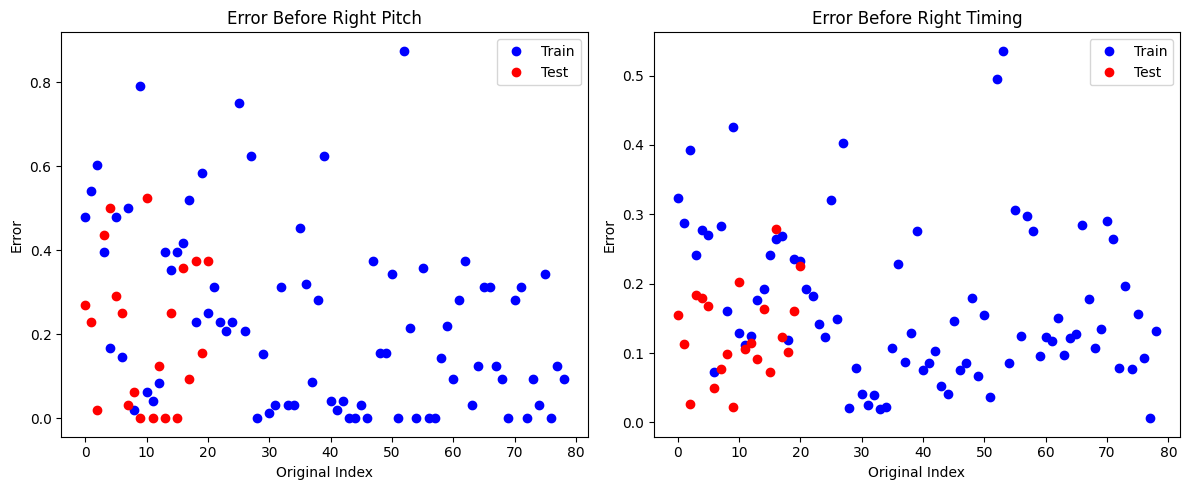

In [6]:
# Plot 'error_before_right_pitch' for train and test data
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Error Before Right Pitch')
plt.plot(train_data.index, train_data['error_before_right_pitch'], 'bo', label='Train')
plt.plot(test_data.index, test_data['error_before_right_pitch'], 'ro', label='Test')

# Add labels and legends for the first plot
plt.xlabel('Original Index')
plt.ylabel('Error')
plt.legend()

# Plot 'error_before_right_timing' for train and test data
plt.subplot(1, 2, 2)
plt.title('Error Before Right Timing')
plt.plot(train_data.index, train_data['error_before_right_timing'], 'bo', label='Train')
plt.plot(test_data.index, test_data['error_before_right_timing'], 'ro', label='Test')

# Add labels and legends for the second plot
plt.xlabel('Original Index')
plt.ylabel('Error')
plt.legend()

# Adjust subplot spacing
plt.tight_layout()

# Show the plots
plt.show()

In [7]:
expert_data

,midi_filename,username,practice_mode,bpm,error_before_left_timing,error_before_right_timing,error_before_left_pitch,error_before_right_pitch,error_after_left_timing,error_after_right_timing,error_after_left_pitch,error_after_right_pitch
18,74a_HaKovaSheli.midi,subjec1_3,IMP_PITCH,72.0,0.0,0.287713,0.0,0.541667,0.0,0.155211,0.0,0.270833
19,74a_HaKovaSheli.midi,subjec1_3,IMP_PITCH,72.0,0.0,0.155211,0.0,0.270833,0.0,0.392252,0.0,0.604167
20,74a_HaKovaSheli.midi,subjec1_3,IMP_TIMING,72.0,0.0,0.392252,0.0,0.604167,0.0,0.324210,0.0,0.479167
21,74a_HaKovaSheli.midi,subjec1_3,IMP_PITCH,72.0,0.0,0.324210,0.0,0.479167,0.0,0.307848,0.0,0.625000
7,74a_HaKovaSheli.midi,subject3_2,IMP_PITCH,85.0,0.0,0.270300,0.0,0.479167,0.0,0.241647,0.0,0.395833
...,...,...,...,...,...,...,...,...,...,...,...,...
5,song9.midi,subject3_1,IMP_TIMING,85.0,0.0,0.078363,0.0,0.000000,0.0,0.092157,0.0,0.000000
6,song9.midi,subject3_1,IMP_TIMING,85.0,0.0,0.092157,0.0,0.000000,0.0,0.022047,0.0,0.000000
2,song9.midi,t_1,IMP_TIMING,85.0,0.0,0.226084,0.0,0.375000,0.0,0.005800,0.0,0.125000
3,song9.midi,t_1,IMP_PITCH,85.0,0.0,0.005800,0.0,0.125000,0.0,0.131552,0.0,0.093750


In [8]:
class PracticeMode(enum.Enum):
    """
    All possible practice modes
    """
    IMP_PITCH = 0
    IMP_TIMING = 1
    LEFT = 2
    RIGHT = 3


# interval of possible bpm_values
BPM_BOUNDS = [50, 200]
class GaussianProcess:
    def __init__(self, bpm_norm_fac=100):
        self.data_X = None
        self.data_X_old_shape = None

        self.data_Y = None

        self.bpm_norm_fac = bpm_norm_fac

        self.domain = [
            {'name': 'practice_mode', 'type': 'categorical', 'domain': (0, 1, 2, 3)},
            {'name': 'bpm', 'type': 'continuous', 'domain':
                (self._norm_bpm(BPM_BOUNDS[0]), self._norm_bpm(BPM_BOUNDS[1]))},
            {'name': 'error_pitch_right', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'error_timing_right', 'type': 'continuous', 'domain': (0, 1)}
        ]

        self.space = GPyOpt.core.task.space.Design_space(self.domain)
        self.kernel = None

    def _norm_bpm(self, v: float) -> float:
        
        return v / self.bpm_norm_fac

    def _params2domain(self, error, bpm: int, practice_mode: PracticeMode):
        domain_x = [
            practice_mode.value,
            self._norm_bpm(bpm),
            error['pitch_right'],
            error['timing_right']
        ]

        return np.array([domain_x])

    def _domain2space(self, domain_x):
        # Converts the domain variables into the GPs input space
        
        
        space_rep = self.space.unzip_inputs(domain_x) 
        
        return space_rep 

    def _get_bayes_opt(self) -> BayesianOptimization:
        return self.bayes_opt

    def update_model(self):
       
        """
        If the Gaussian Process' training data has changed, "trains" the GP on the complete data set.
        """
        if self.data_X is None or self.data_X.shape == self.data_X_old_shape:
            return

        self.data_X_old_shape = self.data_X.shape

       
        self.bayes_opt = GPyOpt.methods.BayesianOptimization(
            f=None, domain=self.domain, X=self.data_X, Y=self.data_Y,
            maximize=True, normalize_Y=True,
            kernel=self.kernel
        )
        
        self.bayes_opt.model.max_iters = 5
        
        self.bayes_opt._update_model()

    def get_estimate(self, error, bpm, practice_mode: PracticeMode) -> float:
        """
        Estimates the utility value for a given practice mode
        @param error: error values
        @param bpm: bpm of the music piece
        @param practice_mode: the practice mode for which the utility value should be estimated
        @return: gaussian process' estimate of the utility value
        """
        if not hasattr(self, "bayes_opt"):
            # if there is no model yet, e.g. in the first iteration return random utility
            return random.random()

        bayes_opt = self._get_bayes_opt()

        x = self._params2domain(error, bpm, practice_mode)
        x = self._domain2space(x)

        mean, var = bayes_opt.model.predict(x)
        

        return mean[0]

    def get_best_practice_mode(self, error, bpm, epsilon=0):
        """
        computes the gaussian process' estimate of the best practice mode
        currently utilizes epsilon-greedy exploration
        @param error: error values
        @param bpm: bpm of the music piece
        @param (optional) epsilon: the probability of making a random decision. set to 0 for no exploration.
        @return: chosen for given input parameters PracticeMode
        """
        left = False
        right = True
        if left and right:
            all_practice_modes = list(PracticeMode)
        else:
            all_practice_modes = [PracticeMode.IMP_PITCH, PracticeMode.IMP_TIMING]
        # epsilon-greedy
        if random.random() > epsilon:
            max_i = np.argmax([self.get_estimate(error, bpm, pm)
                               for pm in all_practice_modes])
            return all_practice_modes[max_i]
        else:
            return np.random.choice(all_practice_modes)

    def add_data_point(self, error, bpm: int, practice_mode: PracticeMode,
                       utility_measurement: float):
        """
        Adds a new datapoint to the dataset of the gaussian process.
        Does not update the Gaussian Process for the new training data (see: update_model)
        @param error: error values
        @param bpm: bpm of the music piece
        @param practice_mode: practice mode in which the performer practiced
        @param utility_measurement: observed utility value for the given parameters
        """

        new_x = self._params2domain(error, bpm, practice_mode)
        new_y = [utility_measurement]

        if self.data_X is None:
            self.data_X = new_x
            self.data_Y = np.array([new_y])
        else:
            self.data_X = np.vstack((self.data_X, new_x[0]))
            self.data_Y = np.vstack((self.data_Y, new_y[0]))
        
    def update_model_with_kernel(self, kernel):
        self.kernel = kernel
    
    def compare_to_best_policy(self, policy_argmax, best_argmax, best_error_diff=1):
            num_diff_cases = np.sum(np.abs(policy_argmax-best_argmax))
    
            abs_diff = num_diff_cases / policy_argmax.shape[0]

    
            return abs_diff


    # Different functions used to deliver a utility value to the plot_utility function -------------------------------------

    # returns the utility estimate of a gaussian process for a specific practice mode
    def _utility_gp(self, bpm, practice_mode, error_pre):
        return self.get_estimate(error_pre, bpm, practice_mode)

    # wrapper function to abstract arguments gaussian process and practice mode
    def utility_gp(self, bpm, practice_mode):
        return lambda error_pre: self._utility_gp(bpm, practice_mode, error_pre)[0]

    def plot_utility(self, utility_function, density=50, title="Utility", data_points=None):
        plot_data = []
        for i, error_pitch in enumerate(np.linspace(0, 1, density)):
            for j, error_timing in enumerate(np.linspace(0, 1, density)):
                error_pre = {
                    'pitch_right': error_pitch,
                    'timing_right': error_timing
                }
                utility = utility_function(error_pre)

                plot_data.append([error_pitch, error_timing, utility])

        plot_data = np.array(plot_data)

        fig = plt.figure(figsize=(10, 7))
        ax = plt.axes(projection="3d")

        ax.scatter3D(plot_data[:, 0], plot_data[:, 1], plot_data[:, 2], s=8)

        if data_points is not None:
            ax.scatter3D(data_points[:, 0], data_points[:, 1], data_points[:, 2], color="red", alpha=0.6)

        ax.set_title(title)
        ax.set_xlabel('error_pitch')
        ax.set_ylabel('error_timing')
        ax.set_zlabel('utility')
        ax.set_zlim(-100, 100)

        plt.show()

In [9]:
def plot_best_policy(gp, tempo):

    # training_points = {
    #     0: [],  # pitch
    #     1: [],  # timing
    # }

    density = 100
    best_mode = np.zeros((density, density))
    for i, error_pitch in enumerate(np.linspace(0, 1, density)):
        for j, error_timing in enumerate(np.linspace(0, 1, density)):
            best_pm = gp.get_best_practice_mode({
                'pitch_right': error_pitch,
                'timing_right': error_timing
            }, bpm=tempo, epsilon=0)
            if best_pm == PracticeMode.IMP_PITCH:
                best_mode[i][j] = 0
            elif best_pm == PracticeMode.IMP_TIMING:
                best_mode[i][j] = 1
            else:
                best_mode[i][j] = 2

    plt.pcolormesh(np.linspace(0, 1, density), np.linspace(0, 1, density), best_mode)
    plt.title("GP's Estimate for best Practice Mode")
    plt.ylabel("error_pitch")
    plt.xlabel("error_timing")

    cmap = plt.cm.viridis
    custom_lines = [Patch(facecolor=cmap(0.)),
                 Patch(facecolor=cmap(1.))]
    plt.legend(custom_lines, ["IMP_PITCH", "IMP_TIMING"])
    plt.show()

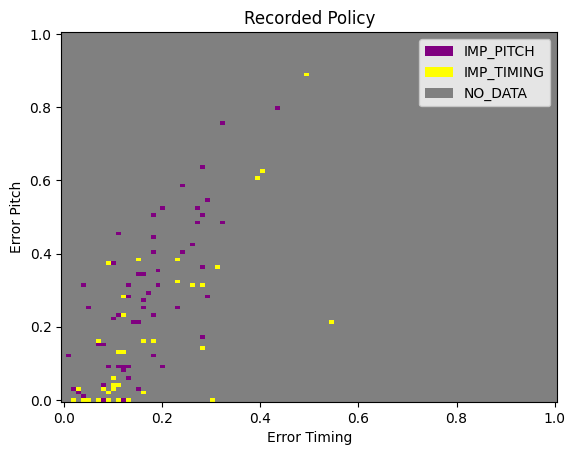

In [10]:
def plot_recorded_policy():
    expert_mode = list(whole_data["practice_mode"])
    
    zipped_data = zip(whole_data["error_before_right_pitch"], whole_data["error_before_right_timing"])
    zipped_data = [(round(x, 2), round(y, 2)) for (x, y) in zipped_data]

    density = 100
    best_mode = np.full((density, density), 2)  # Initialize with the color index for "NO_DATA"
    
    for i, error_pitch in enumerate(np.linspace(0, 1, density)):
        for j, error_timing in enumerate(np.linspace(0, 1, density)):
            target_index = [index for index, tpl in enumerate(zipped_data) if tpl[0] == i/density and tpl[1] == j/density]
            
            if target_index:
                best_pm = expert_mode[target_index[0]]
                if best_pm == "IMP_PITCH":
                    best_mode[i][j] = 0  # Color index for "IMP_PITCH"
                elif best_pm == "IMP_TIMING":
                    best_mode[i][j] = 1  # Color index for "IMP_TIMING"
    
    # Define custom colors
    colors = ["purple", "yellow","grey"]
    
    custom_cmap = ListedColormap(colors)
    
    plt.pcolormesh(np.linspace(0, 1, density), np.linspace(0, 1, density), best_mode, cmap=custom_cmap)
    plt.title("Recorded Policy")
    plt.ylabel("Error Pitch")
    plt.xlabel("Error Timing")
    
    custom_lines = [Patch(facecolor="purple"),  # Color for "IMP_PITCH"
                    Patch(facecolor="yellow"),  # Color for "IMP_TIMING"
                    Patch(facecolor="grey")  # Color for "NO_DATA"
                 ]
    
    plt.legend(custom_lines, ["IMP_PITCH", "IMP_TIMING", "NO_DATA"])
    plt.show()

plot_recorded_policy()


In [11]:
def error_diff_to_utility_for_opt(error_pre_pitch, error_post_pitch, error_pre_timing, error_post_timing, a, MEAN_UTILITY):
    #calculate the difference in both errors between the pre and post error
    #calculate the utility of the difference in errors
    diff_timing = error_post_timing - error_pre_timing
    diff_pitch  = error_post_pitch  - error_pre_pitch
    return -diff_timing*a  -diff_pitch*(1-a)  - MEAN_UTILITY

In [12]:
def calc_utility(recorded_points,a,  mean_utility):
    #calc utility for all expert data
    recorded_points["utility"] = recorded_points.apply(lambda row: error_diff_to_utility_for_opt(row["error_before_right_pitch"],
                                                                                row["error_after_right_pitch"],
                                                                                row["error_before_right_timing"],
                                                                                row["error_after_right_timing"],a, mean_utility), axis=1)
    return recorded_points  

In [13]:
def policy_test(gauss_model, test_points):
    #calculate the policy diff for a single gp, given the recorded points and the expert decision
    policy_diff = []
    practice_mode_map = {'IMP_PITCH': PracticeMode.IMP_PITCH, 'IMP_TIMING': PracticeMode.IMP_TIMING}
    #for all recorded data points
    #recorded_points = calc_utility(test_points, a, mean_utility)
    points =[]
    for i, point in  test_points.iterrows():  # recorded_points.iterrows():


        #point_data = point.drop("utility")
        #expert_opt_policy = point["utility"]
        bpm=point["bpm"]
        given_practice_mode = point["practice_mode"]
        expert_practice_mode = practice_mode_map[given_practice_mode]
        
        if expert_practice_mode == PracticeMode.IMP_PITCH:
            wrong_practice_mode = PracticeMode.IMP_TIMING
        else:
           wrong_practice_mode = PracticeMode.IMP_PITCH
       
        errors = {
        'pitch_right': point['error_before_right_pitch'],
        'timing_right': point['error_before_right_timing']}
 
        best_estimated = gauss_model.get_best_practice_mode(errors, bpm)
        points.append ((errors, bpm,  expert_practice_mode, wrong_practice_mode, best_estimated)) 
        
    
    right_utility = 0
    wrong_utility = 0
    for point in points:
        errors, bpm, expert_practice_mode, wrong_practice_mode, best_estimated = point 
        print ("expert practice mode:", expert_practice_mode,  "best practice mode ", best_estimated)

        if best_estimated == expert_practice_mode:
            right_utility += 1.0
        else:
            wrong_utility += 1.0
    print ("accumulated correct=", right_utility,  "wrong =" ,wrong_utility)
    return wrong_utility/right_utility
        

In [14]:
def policy_add_test(gauss_model, test_points,a,  mean_utility):
    #calculate the policy diff for a single gp, given the recorded points and the expert decision
    # 1) step: add data points to the gauss process 
    policy_diff = []
    practice_mode_map = {'IMP_PITCH': PracticeMode.IMP_PITCH, 'IMP_TIMING': PracticeMode.IMP_TIMING}
    #for all recorded data points
    recorded_points = calc_utility(test_points, a,  mean_utility)
    points =[]
    for i, point in recorded_points.iterrows():


        point_data = point.drop("utility")
        expert_opt_policy = point["utility"]
        bpm=point["bpm"]
        given_practice_mode = point["practice_mode"]
        expert_practice_mode = practice_mode_map[given_practice_mode]
        
        if expert_practice_mode == PracticeMode.IMP_PITCH:
            wrong_practice_mode = PracticeMode.IMP_TIMING
        else:
           wrong_practice_mode = PracticeMode.IMP_PITCH
       
        errors = {
        'pitch_right': point_data['error_before_right_pitch'],
        'timing_right': point_data['error_before_right_timing']}

 
        gauss_model.add_data_point(errors ,bpm, expert_practice_mode, expert_opt_policy)
        
    gauss_model.update_model()
    
    # estimate the quality of prediction

    for i, point in recorded_points.iterrows():


        point_data = point.drop("utility")
        expert_opt_policy = point["utility"]
        bpm=point["bpm"]
        given_practice_mode = point["practice_mode"]
        expert_practice_mode = practice_mode_map[given_practice_mode]
        
        if expert_practice_mode == PracticeMode.IMP_PITCH:
            wrong_practice_mode = PracticeMode.IMP_TIMING
        else:
           wrong_practice_mode = PracticeMode.IMP_PITCH
       
        errors = {
        'pitch_right': point_data['error_before_right_pitch'],
        'timing_right': point_data['error_before_right_timing']}

 
        best_estimated = gauss_model.get_best_practice_mode(errors, bpm)
        points.append ((errors, bpm,  expert_practice_mode, wrong_practice_mode, best_estimated)) 
        
    
    right_utility = 0
    wrong_utility = 0
    for point in points:
        errors, bpm, expert_practice_mode, wrong_practice_mode, best_estimated = point 
        #print ("expert practice mode:", expert_practice_mode,  "best practice mode ", best_estimated)

        if best_estimated == expert_practice_mode:
            right_utility += 1.0
        else:
            wrong_utility += 1.0
    print ("accumulated correct=", right_utility,  "wrong =" ,wrong_utility)
    return wrong_utility/right_utility
        

In [15]:
def optimal_gp(gauss_models, policy_diff):
    #we choose the gp with the lowest mean policy diff
    best_model_index = np.argmin([np.mean(pd) for pd in policy_diff])
    best_model = gauss_models[best_model_index]
    return best_model



In [16]:
gp_list = []
policy_diff_list = []

In [17]:

def objective_function(x, kernel_type):
    #objective function for the optimization of the hyperparameters, getting the mean policy diff for the current hyperparameters
    if x.ndim > 1:
        x = x.flatten()
        
    # x is a list of hyperparameters
    a, mean_utility = x
    print (a, mean_utility)
    # Initialize a GP model with the given hyperparameters and kernel type
    # per calculation of the objective function we calculate the whole prediction of the gaussian process and compare it to the ground truth data. 
    gp = GaussianProcess()
    
    #gp.space.model_dimensionality
    if kernel_type == 'Matern52':
        kernel = GPy.kern.Matern52(input_dim=gp.space.model_dimensionality, ARD=True)
    elif kernel_type == 'RBF':
        kernel = GPy.kern.RBF(input_dim=gp.space.model_dimensionality, ARD=True)
    elif kernel_type == 'RatQuad':
        kernel = GPy.kern.RatQuad(input_dim=gp.space.model_dimensionality, ARD=True)
    elif kernel_type == 'Poly':
        kernel = GPy.kern.Poly(input_dim=gp.space.model_dimensionality, degree=1, variance=1.0, scale=1.0, offset=0.0, ARD=True)
    elif kernel_type == 'Exp':
        kernel = GPy.kern.Exponential(input_dim=gp.space.model_dimensionality, ARD=True)
    else:
        raise ValueError("Invalid kernel type")

    gp.update_model_with_kernel(kernel)

    # Calculate the utility using the expert data and the GP model
    recorded_points =  expert_data [[  #'error_before_left_timing',
     'error_before_right_timing',
       'error_before_right_pitch',
        'error_after_right_timing',
       'error_after_right_pitch', "practice_mode", "bpm"]]

    policy_diff=    policy_add_test(gp,recorded_points,a, mean_utility) #policy_diff_for_single_gp(gp, recorded_points,a, mean_utility)
    gp_list.append(gp)
    policy_diff_list.append(policy_diff)
    #plot_best_policy(gp, 70)
    return policy_diff
  


running kernel Matern52
0.9014286128198323 -8.83832775663601
accumulated correct= 35.0 wrong = 65.0
0.4639878836228102 7.323522915498703
accumulated correct= 30.0 wrong = 70.0
0.1973169683940732 2.0223002348641756
accumulated correct= 37.0 wrong = 63.0
-0.687962719115127 4.161451555920909
accumulated correct= 37.0 wrong = 63.0
-0.6880109593275947 -9.588310114083951
accumulated correct= 44.0 wrong = 56.0
-0.6981294732467856 -9.566168606784453
accumulated correct= 37.0 wrong = 63.0
num acquisition: 1, time elapsed: 0.56s
0.1705116746531763 2.0057041503642155
accumulated correct= 38.0 wrong = 62.0
num acquisition: 2, time elapsed: 1.06s
-0.6810610482761901 -9.603686271773116
accumulated correct= 44.0 wrong = 56.0
num acquisition: 3, time elapsed: 1.54s
-0.6712050866306747 -9.590385944983394
accumulated correct= 45.0 wrong = 55.0
num acquisition: 4, time elapsed: 2.29s
-0.72118701476626 -9.623284226829794
accumulated correct= 38.0 wrong = 62.0
num acquisition: 5, time elapsed: 2.90s
-0.641

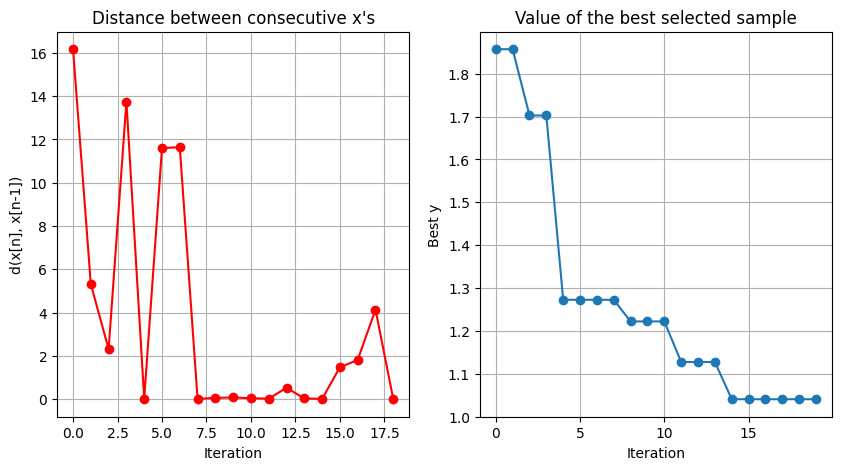

best hyperparams [-0.44211023 -9.06065019]
best policy diff 1.0408163265306123
running kernel RatQuad
0.9654602097158647 -0.2478447988968675
accumulated correct= 41.0 wrong = 59.0
0.36907948101017163 -0.10609290083266565
accumulated correct= 29.0 wrong = 71.0
-0.25437264567127893 5.354375296427069
accumulated correct= 46.0 wrong = 54.0
-0.805949921845776 4.523532511445049
accumulated correct= 35.0 wrong = 65.0
-0.6372644794583802 -5.9745392296436535
accumulated correct= 38.0 wrong = 62.0
-0.20721929606862077 -8.511958845430186
accumulated correct= 37.0 wrong = 63.0
num acquisition: 1, time elapsed: 0.47s
-0.2402459149443954 5.363526912490873
accumulated correct= 37.0 wrong = 63.0
num acquisition: 2, time elapsed: 1.04s
-0.6868472342818288 -5.938439036010417
accumulated correct= 40.0 wrong = 60.0
num acquisition: 3, time elapsed: 1.52s
0.5761208919258178 0.7397276874726426
accumulated correct= 31.0 wrong = 69.0
num acquisition: 4, time elapsed: 2.05s
-0.2641963494351895 5.34801442090972

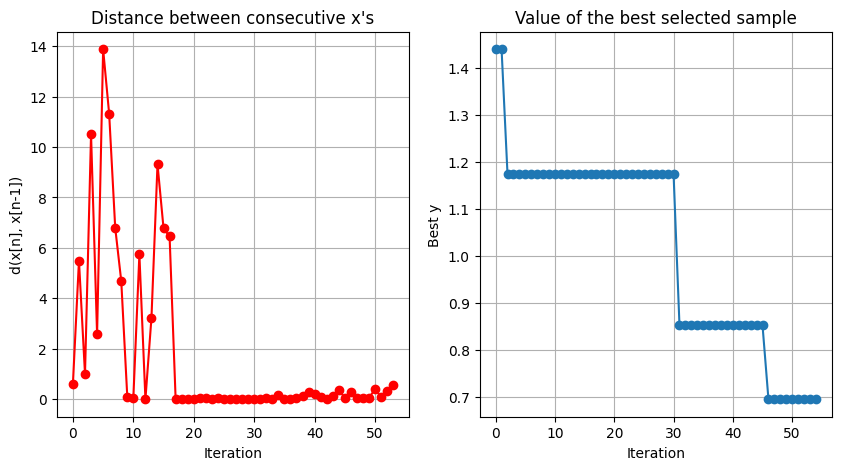

best hyperparams [-1.         -6.67963017]
best policy diff 0.6949152542372882
running kernel RBF
0.6681632704918687 -2.8436910655541636
accumulated correct= 31.0 wrong = 69.0
0.84138229929362 -6.951401447064027
accumulated correct= 38.0 wrong = 62.0
-0.4089063710017826 -2.729038583866121
accumulated correct= 35.0 wrong = 65.0
-0.8422367151695442 7.954508914937854
accumulated correct= 35.0 wrong = 65.0
-0.9232326138392108 -5.347582295002942
accumulated correct= 39.0 wrong = 61.0
-0.6557782830648792 -5.610325615606484
accumulated correct= 39.0 wrong = 61.0
num acquisition: 1, time elapsed: 0.56s
-1.0 -6.472021873969917
accumulated correct= 37.0 wrong = 63.0
num acquisition: 2, time elapsed: 1.09s
0.41108550927325965 -5.760029594459459
accumulated correct= 36.0 wrong = 64.0
num acquisition: 3, time elapsed: 1.59s
1.0 -7.988874658186933
accumulated correct= 30.0 wrong = 70.0
num acquisition: 4, time elapsed: 2.13s
-1.0 -5.738575365160966
accumulated correct= 46.0 wrong = 54.0
num acquisit

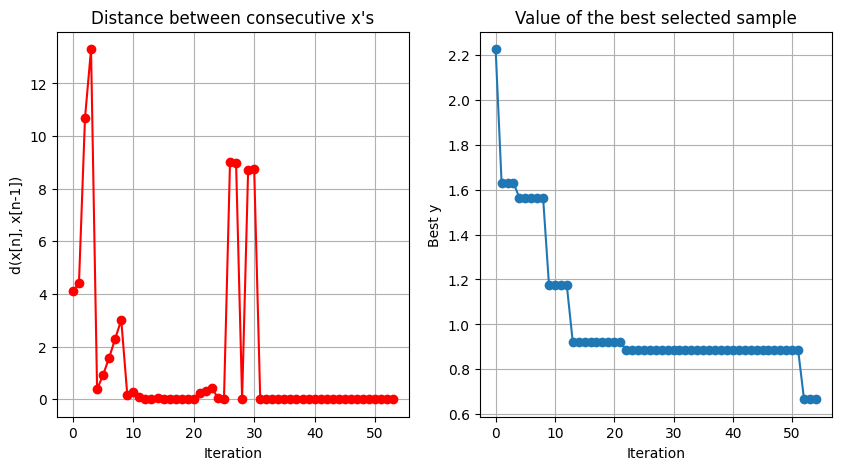

best hyperparams [-1.         -5.63152941]
best policy diff 0.6666666666666666


In [18]:
#initialize the hyper parameters bound for different kernels
kernel_types = ['Matern52', 'RatQuad', 'RBF']
bounds = [{'name': 'a', 'type': 'continuous', 'domain': (-1, 1)},       
          {'name': 'mean_utility', 'type': 'continuous', 'domain': (-10,10)}]

best_gp_dict ={}
best_gp_dict_policy = {}
#for each kernel
for kernel_type in kernel_types:
#do baysian optimization
    print ("running kernel", kernel_type)
            
    # object function includes the definition of the kernel type, not the kernel object.     
    obj_func = lambda x: objective_function(x, kernel_type)
    
    # set the bounds for the optimization process here! 
    bo = BayesianOptimization(f=obj_func,
                              domain=bounds,
                              acquisition_type='EI',
                              acquisition_jitter=0.05,
                              num_cores=10)
    
    # iterate over the bounds at least as many times. 
    bo.run_optimization(max_iter=50, verbosity=True)
       
    # Get the best set of hyperparameters
    bo.plot_convergence()

    best_hyperparameters = bo.x_opt
    best_mean_policy_diff = bo.fx_opt

    print ("best hyperparams", bo.x_opt)
    print ("best policy diff", bo.fx_opt)
    
    best_gp_dict[kernel_type] = best_hyperparameters
    best_gp_dict_policy[kernel_type] = best_mean_policy_diff
    # code that visualizes non-zero part of the input space and the predictions of the best GP model for the best set of hyperparameters
    
   

In [19]:
best_gp_dict
# best_gp_dict_policy

{'Matern52': array([-0.44211023, -9.06065019]),
 'RatQuad': array([-1.        , -6.67963017]),
 'RBF': array([-1.        , -5.63152941])}

In [20]:
best_gp_dict_policy

{'Matern52': 1.0408163265306123,
 'RatQuad': 0.6949152542372882,
 'RBF': 0.6666666666666666}

In [21]:
best_kernel_type = min(best_gp_dict_policy, key=best_gp_dict_policy.get) 
best_param = best_gp_dict[best_kernel_type]
#get a dict of the parameters for the best kernel with its name as the key, and also the best mean policy diff and the kernel type
best_param_dict = dict(zip([b['name'] for b in bounds], best_param))
best_kernel = {"name": best_kernel_type, "best parameters": best_param_dict, "policy-diff": best_gp_dict_policy[best_kernel_type]}


In [22]:
best_kernel

{'name': 'RBF',
 'best parameters': {'a': -1.0, 'mean_utility': -5.631529408880295},
 'policy-diff': 0.6666666666666666}

In [23]:
gp= optimal_gp(gp_list,policy_diff_list)
gp.kernel

rbf.,value,constraints,priors
variance,0.3478032399967835,+ve,
lengthscale,"(7,)",+ve,


In [24]:
gp.kernel.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],1.81282911,+ve,
[1],0.74563358,+ve,
[2],0.34968333,+ve,
[3],0.44899758,+ve,
[4],0.83644772,+ve,
[5],0.64807391,+ve,
[6],0.58446128,+ve,


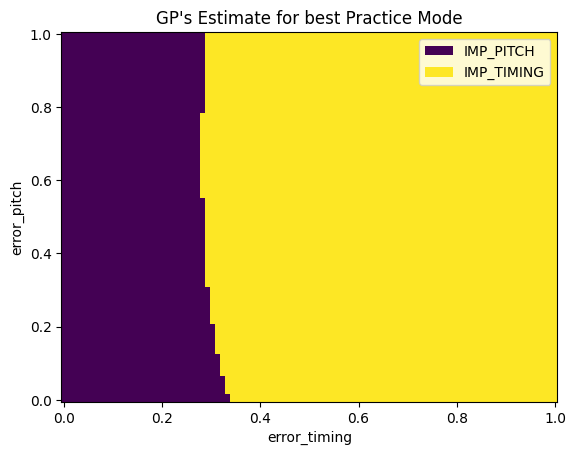

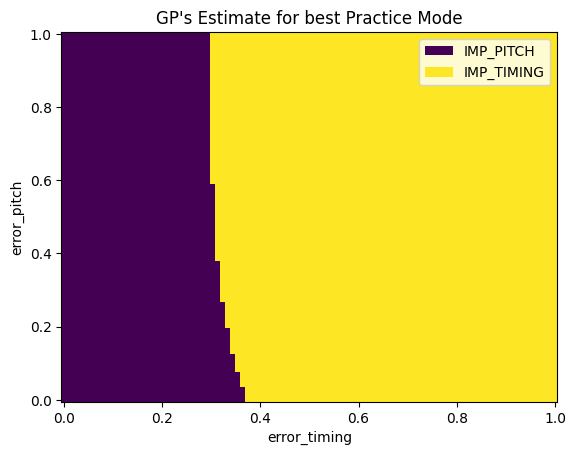

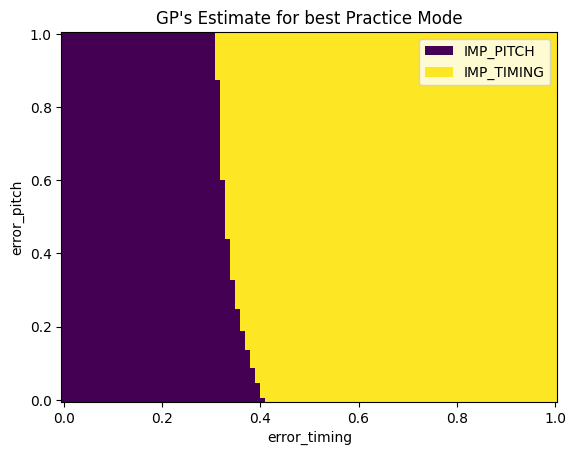

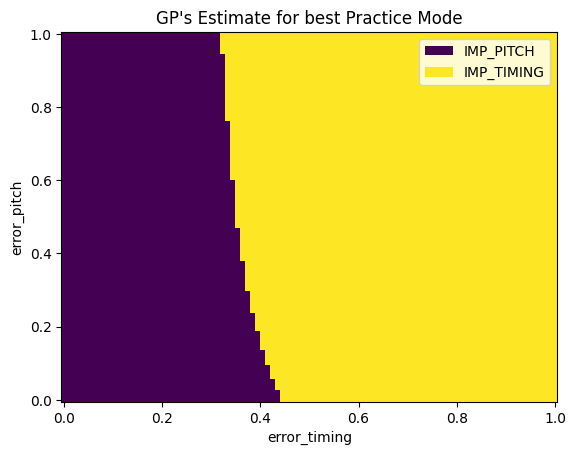

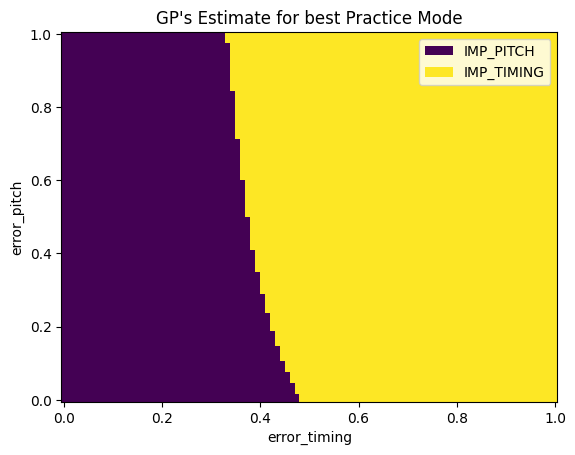

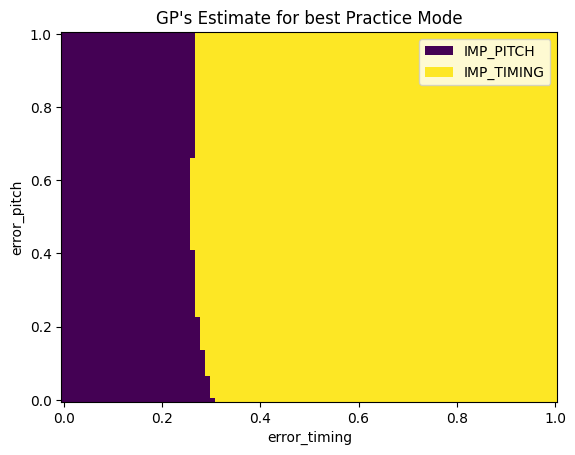

expert practice mode: PracticeMode.IMP_PITCH best practice mode  PracticeMode.IMP_PITCH
expert practice mode: PracticeMode.IMP_PITCH best practice mode  PracticeMode.IMP_PITCH
expert practice mode: PracticeMode.IMP_TIMING best practice mode  PracticeMode.IMP_TIMING
expert practice mode: PracticeMode.IMP_PITCH best practice mode  PracticeMode.IMP_TIMING
expert practice mode: PracticeMode.IMP_PITCH best practice mode  PracticeMode.IMP_PITCH
expert practice mode: PracticeMode.IMP_PITCH best practice mode  PracticeMode.IMP_PITCH
expert practice mode: PracticeMode.IMP_PITCH best practice mode  PracticeMode.IMP_PITCH
expert practice mode: PracticeMode.IMP_PITCH best practice mode  PracticeMode.IMP_TIMING
expert practice mode: PracticeMode.IMP_TIMING best practice mode  PracticeMode.IMP_PITCH
expert practice mode: PracticeMode.IMP_PITCH best practice mode  PracticeMode.IMP_PITCH
expert practice mode: PracticeMode.IMP_PITCH best practice mode  PracticeMode.IMP_PITCH
expert practice mode: Pract

0.6666666666666666

In [25]:
#calculate optimal model given a list of models and a list of losses

plot_best_policy(gp, 60)
plot_best_policy(gp, 70)
plot_best_policy(gp, 80)
plot_best_policy(gp, 90)
plot_best_policy(gp, 100)
plot_best_policy(gp, 50)
# compare gp policy with expert policy

policy_test(gp,expert_data)


In [26]:
data = combined_df

In [27]:
gp.data_Y


array([[6.04069407],
       [5.20190446],
       [5.81348693],
       [5.32350138],
       [5.7695428 ],
       [5.4646985 ],
       [5.19086584],
       [6.9075304 ],
       [5.45720895],
       [5.69101816],
       [5.28290688],
       [5.75719608],
       [5.92028743],
       [5.58748369],
       [5.66877785],
       [5.38152941],
       [5.4738871 ],
       [5.83547336],
       [5.76683214],
       [5.13348423],
       [5.8712915 ],
       [6.04619119],
       [5.64153408],
       [5.55907218],
       [5.45429254],
       [5.59783297],
       [5.8439422 ],
       [5.99086648],
       [6.11647796],
       [5.6990221 ],
       [5.62414623],
       [5.92017353],
       [6.06183832],
       [6.07009243],
       [5.40837048],
       [6.09477577],
       [5.64032134],
       [5.6281108 ],
       [5.58014629],
       [5.0826503 ],
       [6.23861222],
       [5.61478178],
       [5.6341672 ],
       [5.69606815],
       [6.45535054],
       [6.06553968],
       [5.63118201],
       [6.391

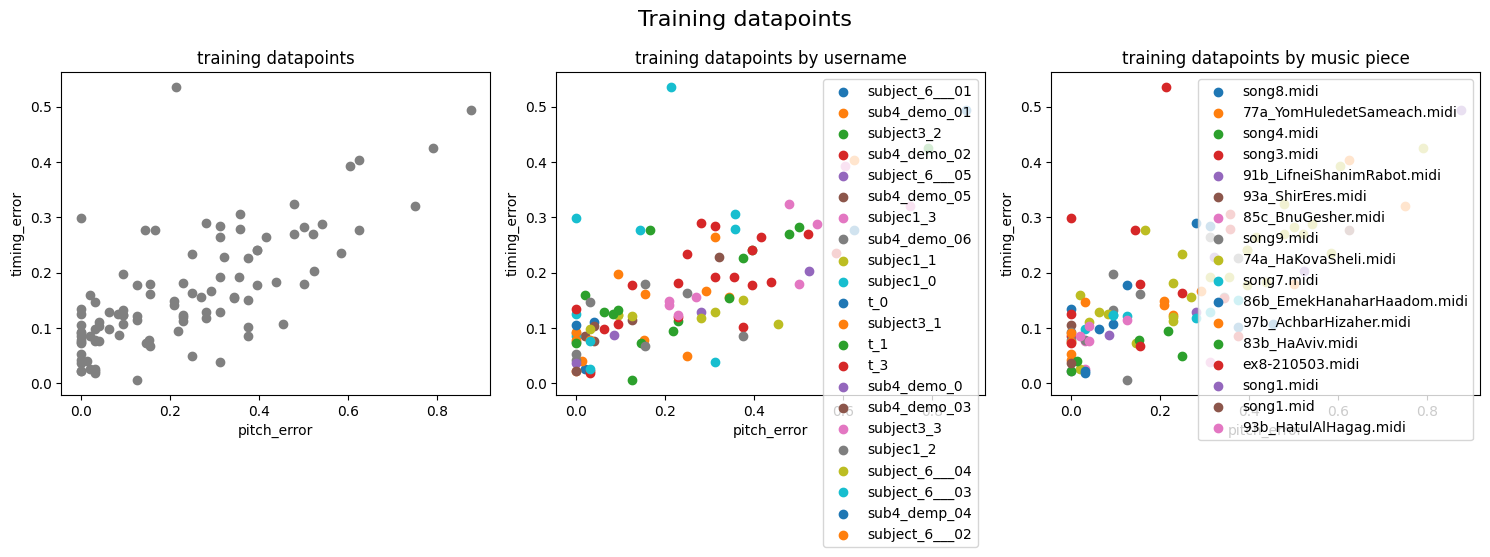

In [28]:
users = list(set(data["username"]))
midi_name = list(set(data["midi_filename"]))

figure, axis = plt.subplots(1, 3, figsize=(15, 5))

axis[0].scatter(data['error_before_right_pitch'], data['error_before_right_timing'], label=None, c='gray')
axis[0].set_title('training datapoints')
axis[0].set_xlabel('pitch_error')
axis[0].set_ylabel('timing_error')

for index, u in enumerate(users):
    axis[1].scatter(data.loc[data["username"] == u]['error_before_right_pitch'],
                    data.loc[data["username"] == u]['error_before_right_timing'], label=u)
axis[1].set_title('training datapoints by username')
axis[1].set_xlabel('pitch_error')
axis[1].set_ylabel('timing_error')
axis[1].legend()

for i, m in enumerate(midi_name):
    axis[2].scatter(data.loc[data["midi_filename"] == m]['error_before_right_pitch'],
                    data.loc[data["midi_filename"] == m]['error_before_right_timing'], label=m)
axis[2].set_title('training datapoints by music piece')
axis[2].set_xlabel('pitch_error')
axis[2].set_ylabel('timing_error')
axis[2].legend()
figure.suptitle("Training datapoints", fontsize=16)
plt.tight_layout()
plt.show()



In [29]:
gp.data_Y

array([[6.04069407],
       [5.20190446],
       [5.81348693],
       [5.32350138],
       [5.7695428 ],
       [5.4646985 ],
       [5.19086584],
       [6.9075304 ],
       [5.45720895],
       [5.69101816],
       [5.28290688],
       [5.75719608],
       [5.92028743],
       [5.58748369],
       [5.66877785],
       [5.38152941],
       [5.4738871 ],
       [5.83547336],
       [5.76683214],
       [5.13348423],
       [5.8712915 ],
       [6.04619119],
       [5.64153408],
       [5.55907218],
       [5.45429254],
       [5.59783297],
       [5.8439422 ],
       [5.99086648],
       [6.11647796],
       [5.6990221 ],
       [5.62414623],
       [5.92017353],
       [6.06183832],
       [6.07009243],
       [5.40837048],
       [6.09477577],
       [5.64032134],
       [5.6281108 ],
       [5.58014629],
       [5.0826503 ],
       [6.23861222],
       [5.61478178],
       [5.6341672 ],
       [5.69606815],
       [6.45535054],
       [6.06553968],
       [5.63118201],
       [6.391

In [30]:
gp.kernel
gp.kernel.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],1.81282911,+ve,
[1],0.74563358,+ve,
[2],0.34968333,+ve,
[3],0.44899758,+ve,
[4],0.83644772,+ve,
[5],0.64807391,+ve,
[6],0.58446128,+ve,


In [31]:
bo.x_opt
#output the kernel parameters of the gaussian process model
a = bo.x_opt[-2]
a




-1.0

In [32]:
def error_diff_to_utility(error_pre, error_post,a, mean_utility):
    diff_timing = (error_pre["timing_left"] + error_pre["timing_right"]) - (
            error_post["timing_left"] + error_post["timing_right"])
    diff_pitch = (error_pre["pitch_left"] + error_pre["pitch_right"]) - (
            error_post["pitch_left"] + error_post["pitch_right"])

    return (a* diff_timing +  (1-a) *diff_pitch) - mean_utility

In [33]:
data

,midi_filename,username,practice_mode,bpm,error_before_left_timing,error_before_right_timing,error_before_left_pitch,error_before_right_pitch,error_after_left_timing,error_after_right_timing,error_after_left_pitch,error_after_right_pitch
0,song3.midi,subjec1_0,IMP_PITCH,85.0,0.0,0.278921,0.0,0.357143,0.0,0.535850,0.0,0.214286
1,song3.midi,subjec1_0,IMP_TIMING,85.0,0.0,0.535850,0.0,0.214286,0.0,0.306054,0.0,0.357143
2,song3.midi,subjec1_0,IMP_TIMING,85.0,0.0,0.306054,0.0,0.357143,0.0,0.298177,0.0,0.000000
3,song3.midi,subjec1_0,IMP_TIMING,85.0,0.0,0.298177,0.0,0.000000,0.0,0.124353,0.0,0.000000
4,song3.midi,subjec1_0,IMP_PITCH,85.0,0.0,0.124353,0.0,0.000000,0.0,0.084995,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
6,85c_BnuGesher.midi,subject_6___03,IMP_PITCH,85.0,0.0,0.038776,0.0,0.312500,0.0,0.020858,0.0,0.000000
7,86b_EmekHanaharHaadom.midi,subject_6___04,IMP_PITCH,85.0,0.0,0.106898,0.0,0.453125,0.0,0.024469,0.0,0.000000
8,91b_LifneiShanimRabot.midi,subject_6___05,IMP_PITCH,85.0,0.0,0.202320,0.0,0.523437,0.0,0.087103,0.0,0.085938
9,91b_LifneiShanimRabot.midi,subject_6___05,IMP_PITCH,85.0,0.0,0.087103,0.0,0.085938,0.0,0.129084,0.0,0.281250
